# Compare fits to mock data using different emulators

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


### Setup emulators

Each run will have its own emulator, that will be the only different thing in the run

In [2]:
# setup run for Pedersen21 emulator
runs={}
runs['Pedersen21']={'emulator':gp_emulator.GPEmulator(training_set='Pedersen21',emulator_label='Pedersen21')}

Selected training set from Pedersen21
Select emulator in Pedersen21
Gaussian Process emulator predicting the P1D at each k-bin. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones.
Training GP on 330 points


 /home/jchaves/miniconda3/envs/py11/lib/python3.11/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 1.13 seconds


In [3]:
# setup run for Pedersen23 emulator
runs['Pedersen23']={'emulator':gp_emulator.GPEmulator(training_set='Pedersen21',emulator_label='Pedersen23')}

Selected training set from Pedersen21
Select emulator in Pedersen23
Gaussian Process emulator predicting the P1D, fitting coefficients to a 4th degree polynomial. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training GP on 330 points
GPs optimised in 0.54 seconds


In [4]:
runs['LaCE-GP']={'emulator':gp_emulator.GPEmulator(training_set='Cabayol23',emulator_label='Cabayol23')}

Selected training set from Cabayol23
Select emulator in Cabayol23
Gaussian Process emulator predicting the P1D, fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training GP on 330 points
GPs optimised in 0.45 seconds


In [5]:
runs['test-C23-P23']={'emulator':gp_emulator.GPEmulator(training_set='Cabayol23',emulator_label='Pedersen23')}

Selected training set from Cabayol23
Select emulator in Pedersen23
Gaussian Process emulator predicting the P1D, fitting coefficients to a 4th degree polynomial. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training GP on 330 points
GPs optimised in 0.55 seconds


In [6]:
runs['test-P12-C23']={'emulator':gp_emulator.GPEmulator(training_set='Pedersen21',emulator_label='Cabayol23')}

Selected training set from Pedersen21
Select emulator in Cabayol23
Gaussian Process emulator predicting the P1D, fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training GP on 330 points
GPs optimised in 0.47 seconds


In [7]:
# setup run for Cabayol23 NN emulator
runs['Cabayol23']={
    'emulator':nn_emulator.NNEmulator(
        training_set='Cabayol23',
        emulator_label='Cabayol23', 
        model_path="NNmodels/Cabayol23/Cabayol23.pt",
        train=False,
    )
}

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


In [8]:
# setup run for the Nyx emulator
runs['Nyx']={
    'emulator':nn_emulator.NNEmulator(
        training_set='Nyx23_Oct2023',
        emulator_label='Nyx_v0', 
        model_path="NNmodels/Nyx23_Oct2023/Nyx_v0.pt",
        train=False,
    )
}

Selected training set from Nyx23_Oct2023
Select emulator in Nyx_v0
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


### Create mock P1D data

Create mock data, mimicking a particular dataset, using the emulator to create the signal

In [9]:
# data_label="QMLE_Ohio"
data_label="Chabanier2019"

In [10]:
for label,run in runs.items():
    print('label',label)
    run['data']=mock_data.Mock_P1D(emulator=run['emulator'],data_label=data_label)

label Pedersen21
label Pedersen23
label LaCE-GP
label test-C23-P23
label test-P12-C23
label Cabayol23
label Nyx


Pedersen21


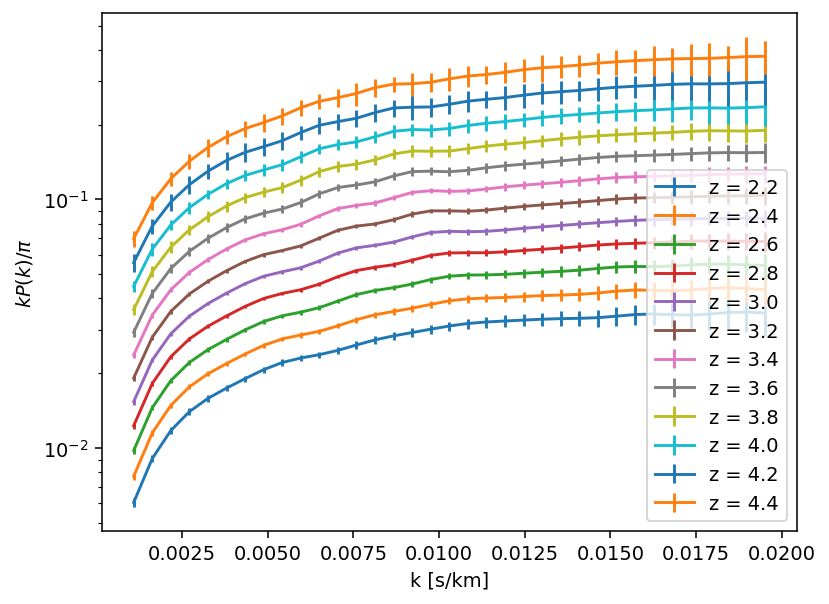

Pedersen23


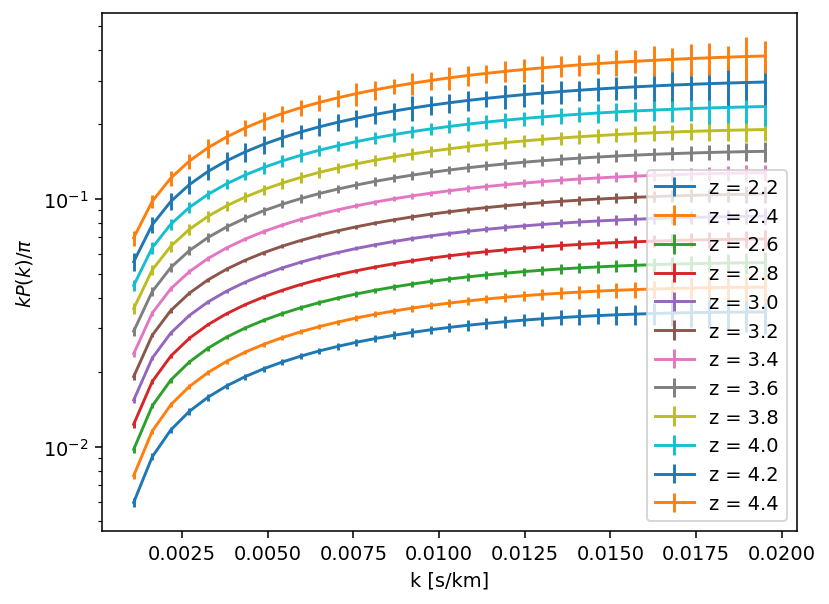

LaCE-GP


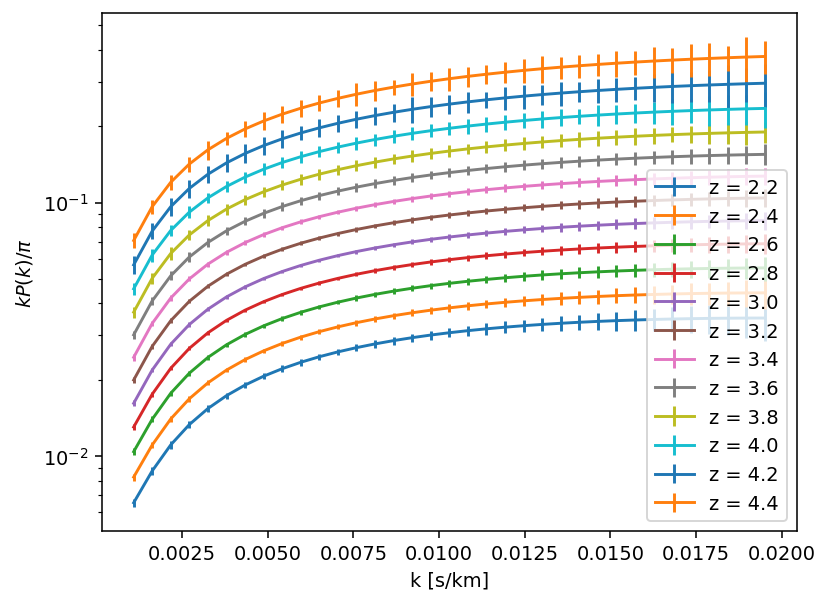

test-C23-P23


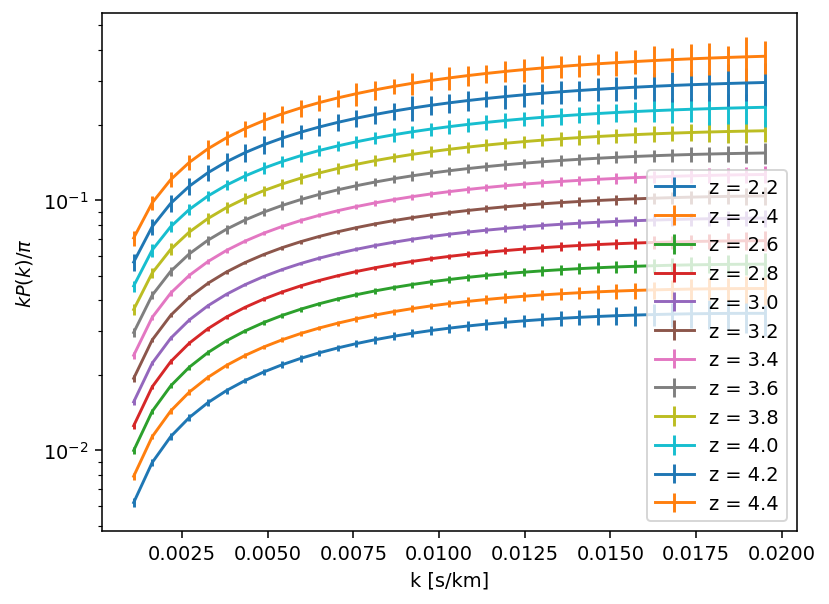

test-P12-C23


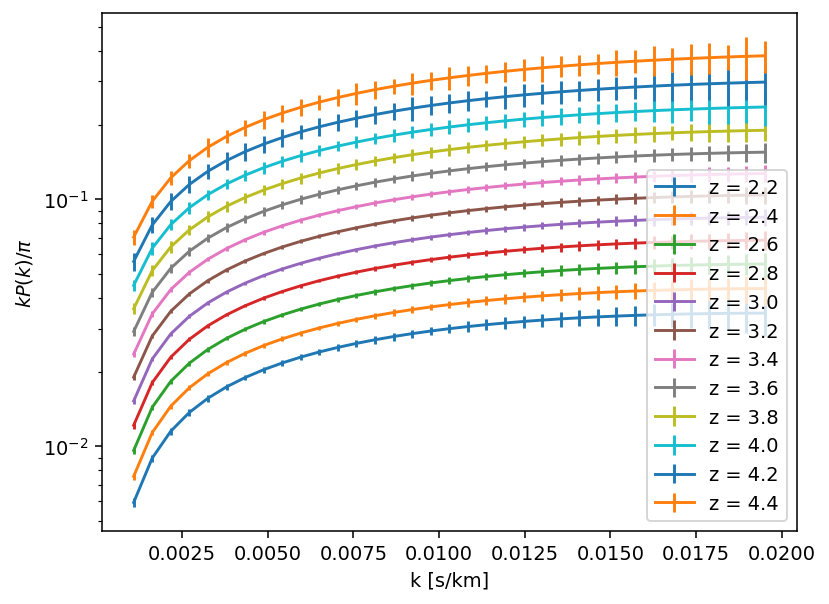

Cabayol23


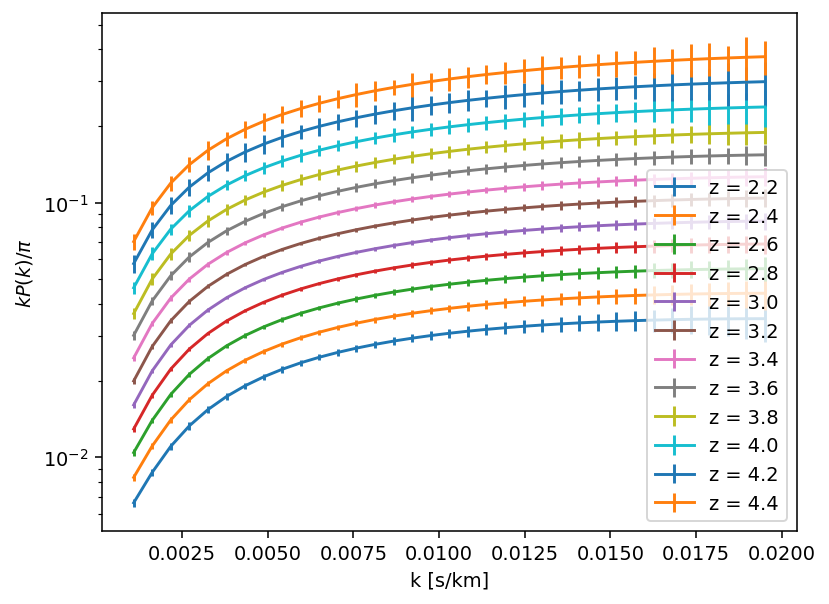

Nyx


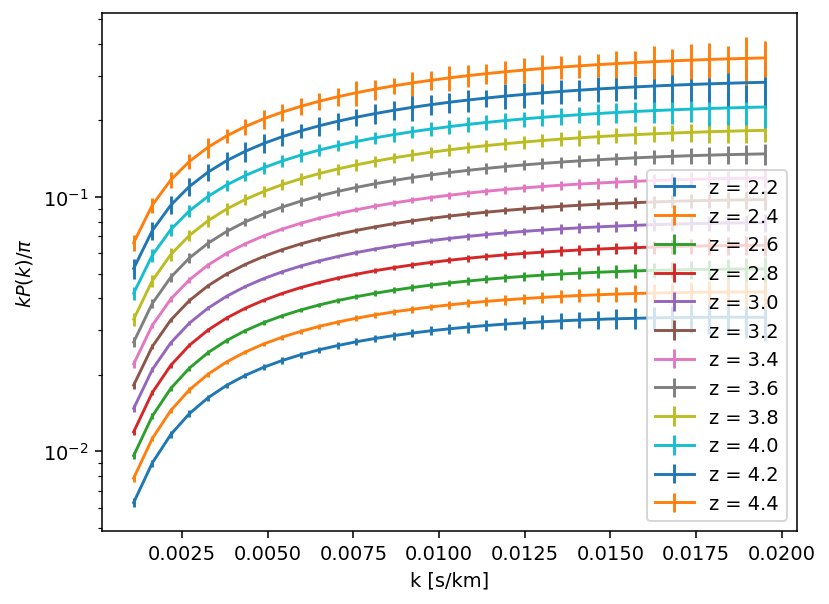

In [11]:
for label,run in runs.items():
    data=run['data']
    print(label)
    data.plot_p1d()

In [12]:
def plot_p1d(runs,iz):
    for label,run in runs.items():
        data=run['data']
        z=data.z[iz]
        print(label,iz,z)
    
        k_kms=data.k_kms
        Pk_kms=data.get_Pk_iz(iz)
        plt.plot(k_kms[:10],Pk_kms[:10],label=label)
        
    plt.title('z = {}'.format(z))
    plt.legend()
    plt.xlabel('k [s/km]')
    plt.ylabel('P(k) [km/s]')

Pedersen21 2 2.6
Pedersen23 2 2.6
LaCE-GP 2 2.6
test-C23-P23 2 2.6
test-P12-C23 2 2.6
Cabayol23 2 2.6
Nyx 2 2.6


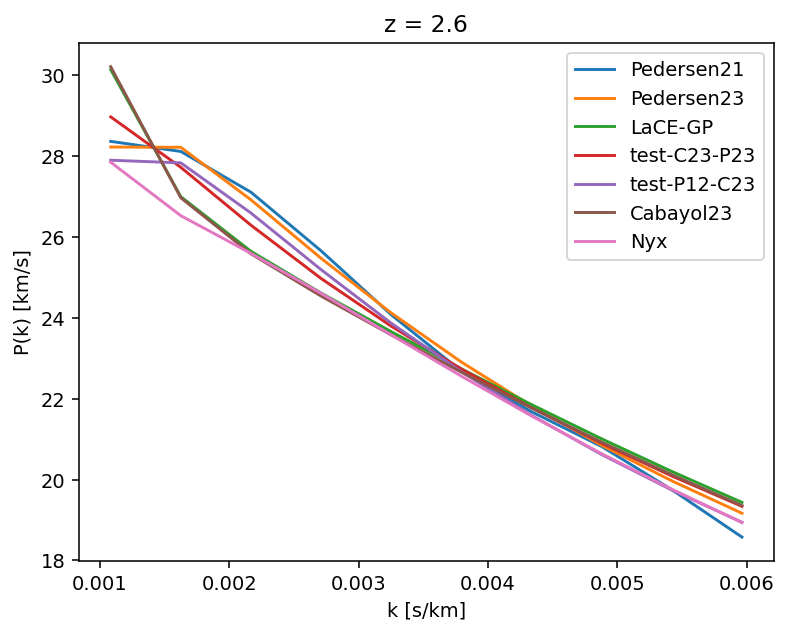

In [13]:
plot_p1d(runs,2)

### Set free parameters and theory

In [14]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [15]:
for label,run in runs.items():
    run['theory']=lya_theory.Theory(zs=run['data'].z,emulator=run['emulator'],free_param_names=free_param_names)

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [16]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
for label,run in runs.items():
    run['likelihood']=like=likelihood.Likelihood(data=run['data'],theory=run['theory'],
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor)

run Pedersen21
As = 2.4250000000000002e-09 , 7.4e-10 , 4.11e-09
ns = 1.0 , 0.68 , 1.32
ln_tau_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_0 = 0.0 , -2.0 , 2.0
ln_gamma_0 = 0.0 , -0.6 , 0.6
ln_kF_0 = 0.0 , -0.8 , 0.8
ln_tau_1 = 0.0 , -1.6 , 1.6
ln_sigT_kms_1 = 0.0 , -5.0 , 5.0
ln_gamma_1 = 0.0 , -1.6 , 1.6
ln_kF_1 = 0.0 , -2.0 , 2.0
chi2 = 617.1960360452682
----------------
run Pedersen23
As = 2.4250000000000002e-09 , 7.4e-10 , 4.11e-09
ns = 1.0 , 0.68 , 1.32
ln_tau_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_0 = 0.0 , -2.0 , 2.0
ln_gamma_0 = 0.0 , -0.6 , 0.6
ln_kF_0 = 0.0 , -0.8 , 0.8
ln_tau_1 = 0.0 , -1.6 , 1.6
ln_sigT_kms_1 = 0.0 , -5.0 , 5.0
ln_gamma_1 = 0.0 , -1.6 , 1.6
ln_kF_1 = 0.0 , -2.0 , 2.0
chi2 = 1045.928228571099
----------------
run LaCE-GP
As = 2.4250000000000002e-09 , 7.4e-10 , 4.11e-09
ns = 1.0 , 0.68 , 1.32
ln_tau_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_0 = 0.0 , -2.0 , 2.0
ln_gamma_0 = 0.0 , -0.6 , 0.6
ln_kF_0 = 0.0 , -0.8 , 0.8
ln_tau_1 = 0.0 , -1.6 , 1.6
ln_sigT_kms_1 = 0.0 , -5.0 , 5.0
ln_gamm

 /home/jchaves/Proyectos/projects/lya/cup1d/src/cup1d/likelihood/likelihood.py:577: UserWarning:Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


----------------
run Nyx
As = 2.4250000000000002e-09 , 7.4e-10 , 4.11e-09
ns = 1.0 , 0.68 , 1.32
ln_tau_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_0 = 0.0 , -2.0 , 2.0
ln_gamma_0 = 0.0 , -0.6 , 0.6
ln_kF_0 = 0.0 , -0.8 , 0.8
ln_tau_1 = 0.0 , -1.6 , 1.6
ln_sigT_kms_1 = 0.0 , -5.0 , 5.0
ln_gamma_1 = 0.0 , -1.6 , 1.6
ln_kF_1 = 0.0 , -2.0 , 2.0
chi2 = 851.9712533262249
----------------


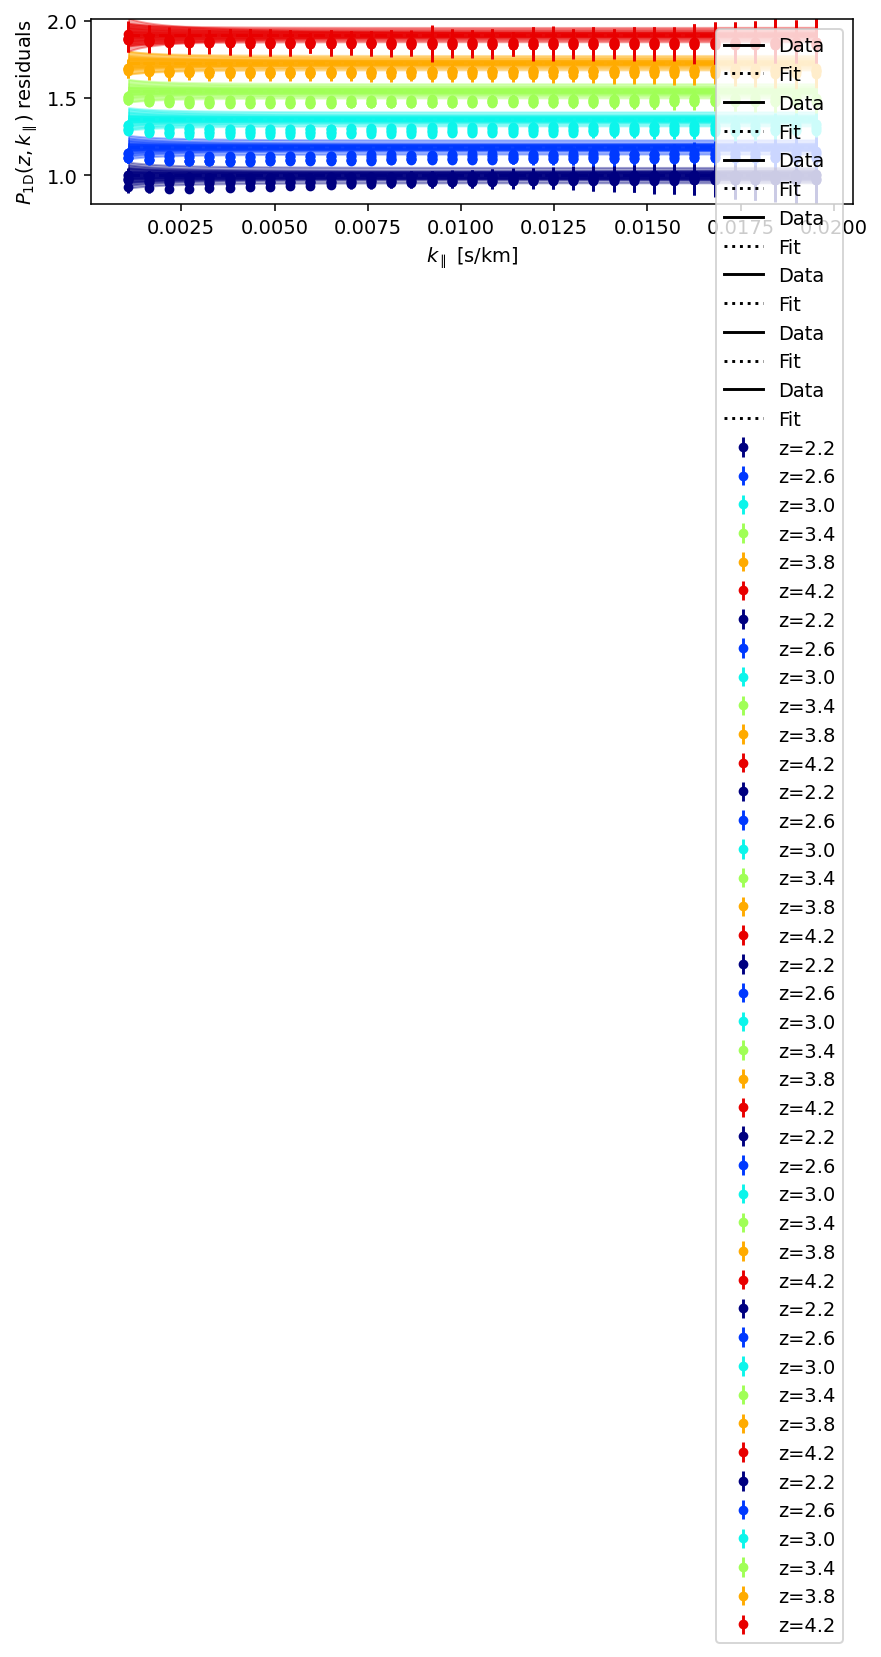

In [17]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for label,run in runs.items():
    print('run',label)
    like=run['likelihood']
    for p in like.parameters_from_sampling_point(values=test_values):
        print(p.info_str(all_info=True))
    print('chi2 =',like.get_chi2(values=test_values))
    like.plot_p1d(values=test_values,residuals=True,plot_every_iz=2)
    print('----------------')

### Run iminuit minimizer

In [18]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.0
ini_values=2*ini_sigma*np.random.random(len(free_param_names))+0.5-ini_sigma
for label,run in runs.items():
    print('minimize run',label)
    # what is the chi2 of the starting point?
    ini_chi2=run['likelihood'].get_chi2(values=ini_values)
    run['minimizer']=iminuit_minimizer.IminuitMinimizer(run['likelihood'],ini_values=ini_values)
    run['minimizer'].minimize(compute_hesse=True)
    # what is the chi2 of the best-fit? (should be close to 0)
    best_fit_values=np.array(run['minimizer'].minimizer.values)
    best_chi2=run['likelihood'].get_chi2(values=best_fit_values)
    print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2)) 

minimize run Pedersen21
chi2 improved from 617.1960360452682 to 1.4680122781425316e-05
minimize run Pedersen23
chi2 improved from 1045.928228571099 to 1.4961458908548814e-05
minimize run LaCE-GP
chi2 improved from 1199.9179084349782 to 1.2489556434745355e-05
minimize run test-C23-P23
chi2 improved from 665.8485859322757 to 0.0007570994180456565
minimize run test-P12-C23
chi2 improved from 1405.488031399146 to 0.00011625687981317031
minimize run Cabayol23
chi2 improved from 986.3212206468863 to 3.9024286827150794e-05
minimize run Nyx
chi2 improved from 851.9712533262249 to 0.0008620704907067008


run Pedersen21
run Pedersen23
run LaCE-GP
run test-C23-P23
run test-P12-C23
run Cabayol23
run Nyx


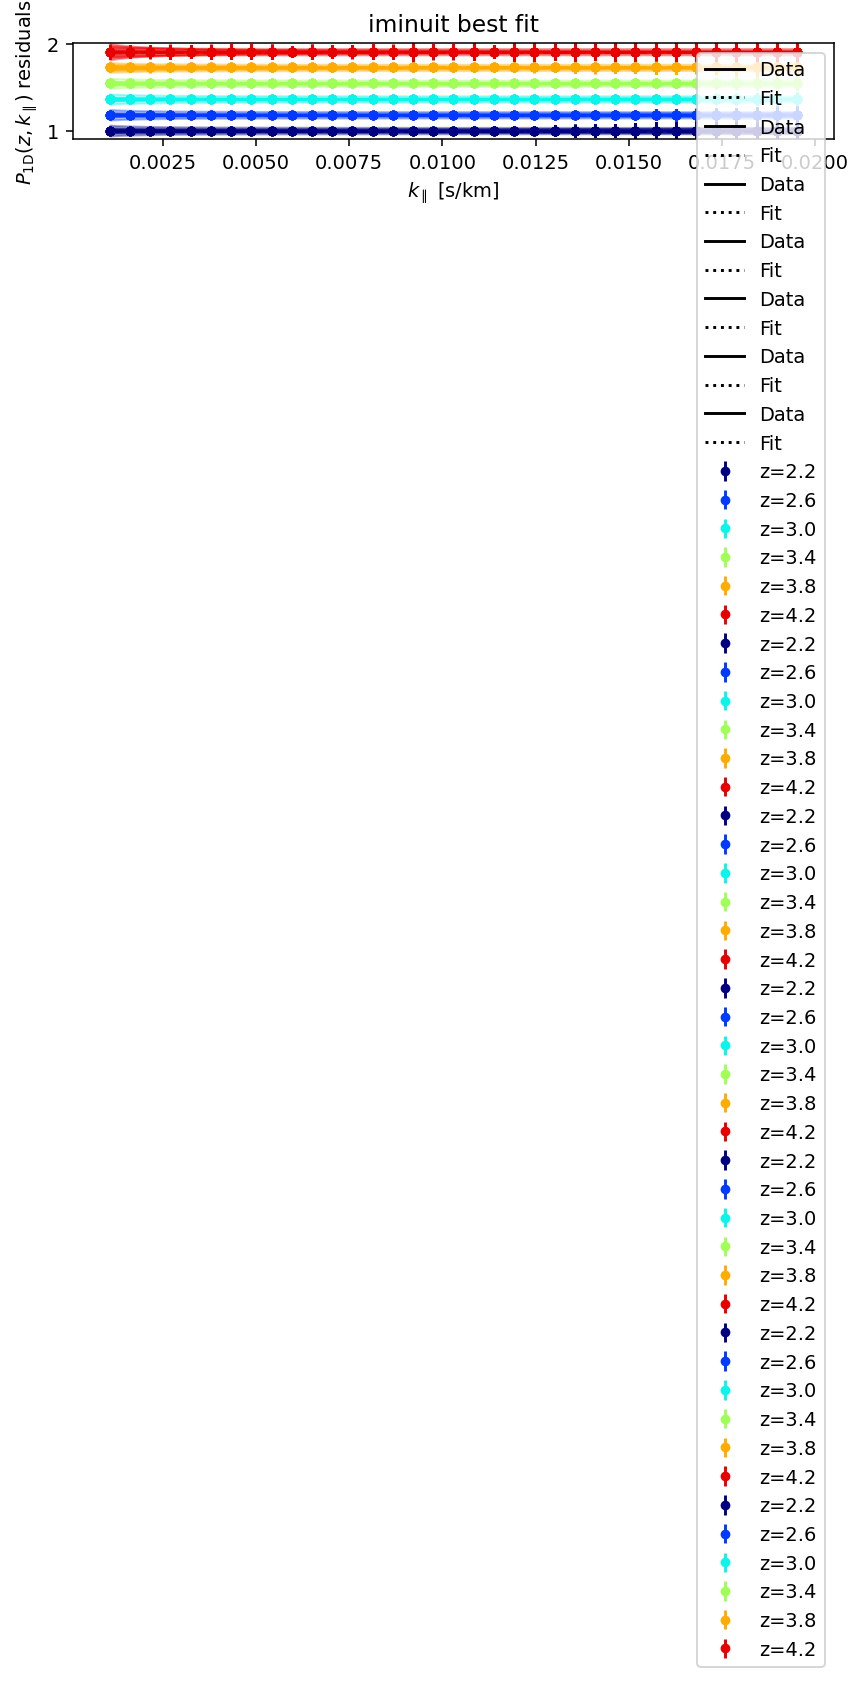

In [19]:
for label,run in runs.items():
    print('run',label)
    run['minimizer'].plot_best_fit(plot_every_iz=2)

run Pedersen21
run Pedersen23
run LaCE-GP
run test-C23-P23
run test-P12-C23
run Cabayol23
run Nyx


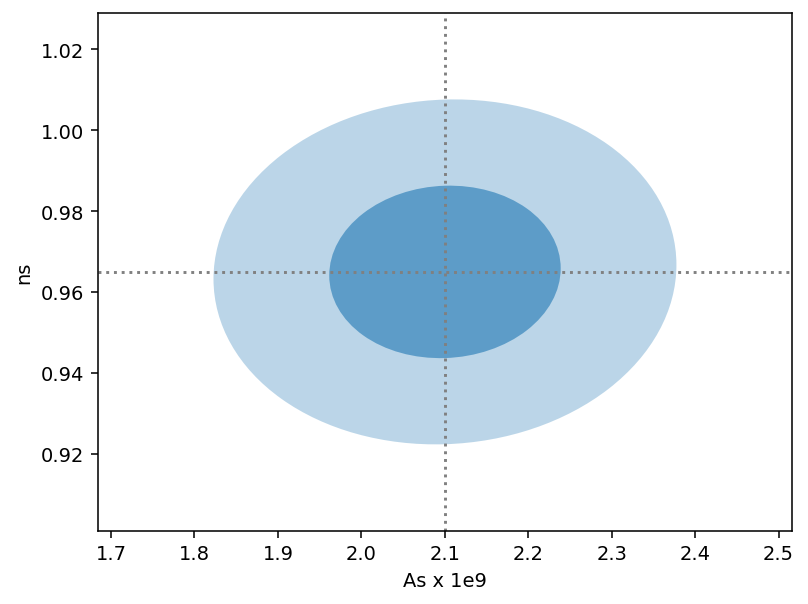

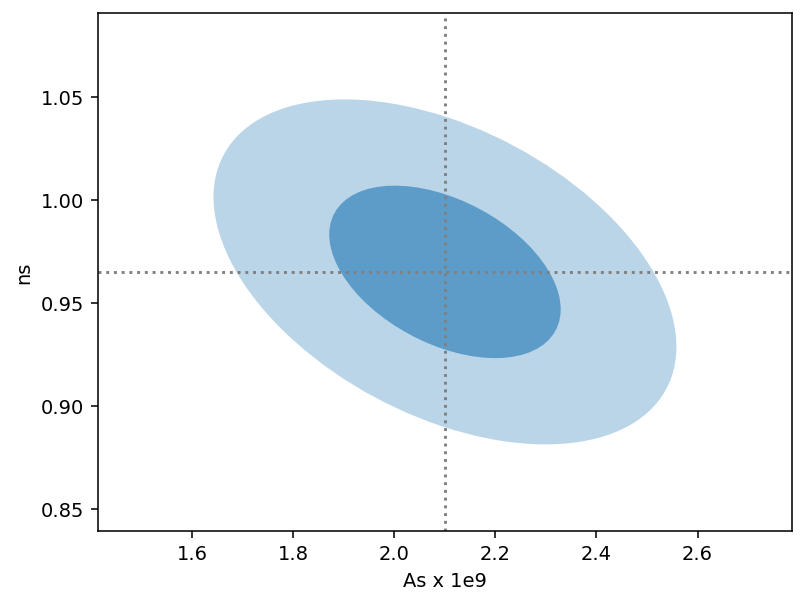

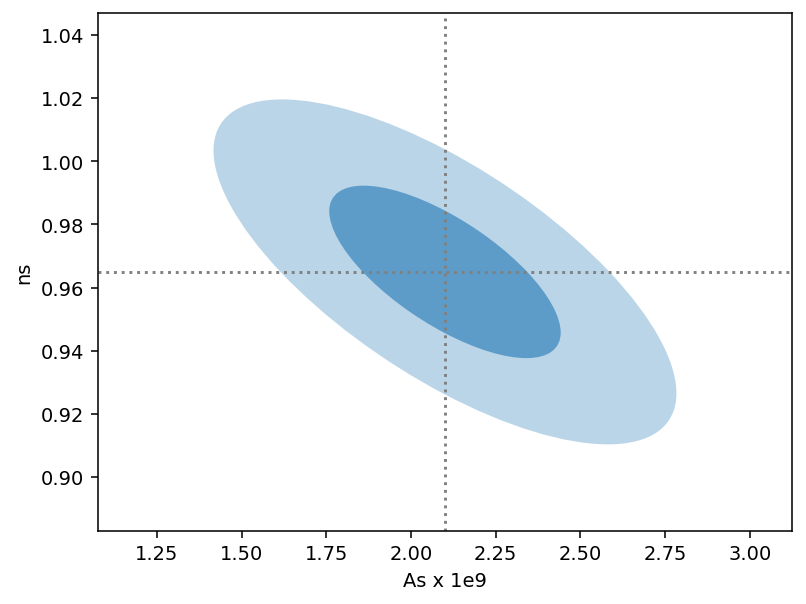

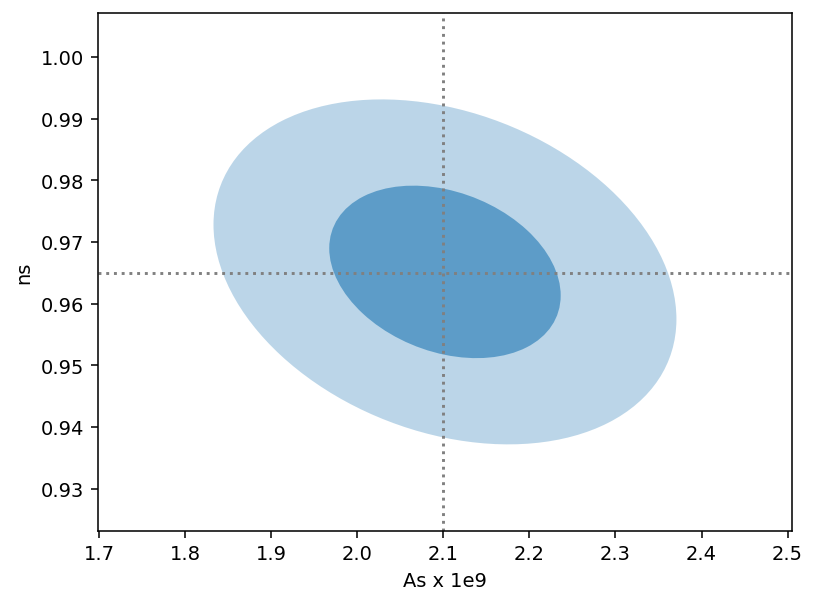

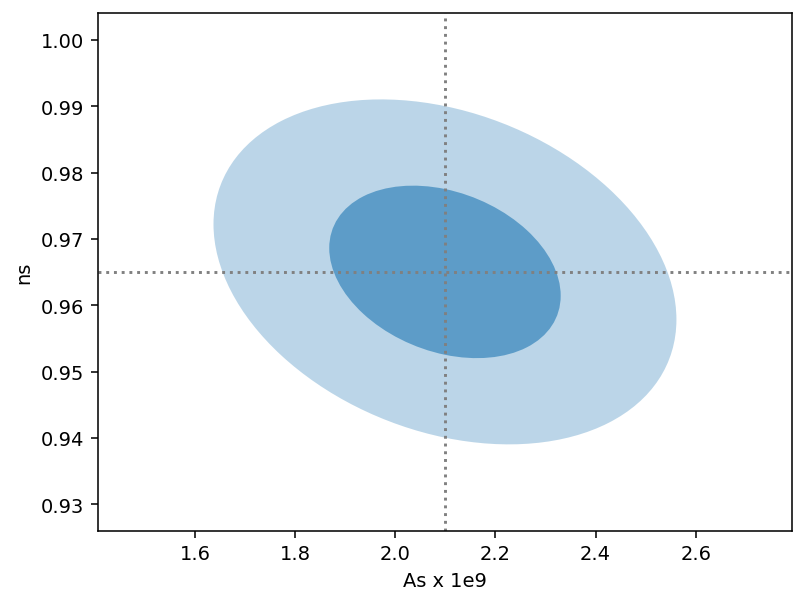

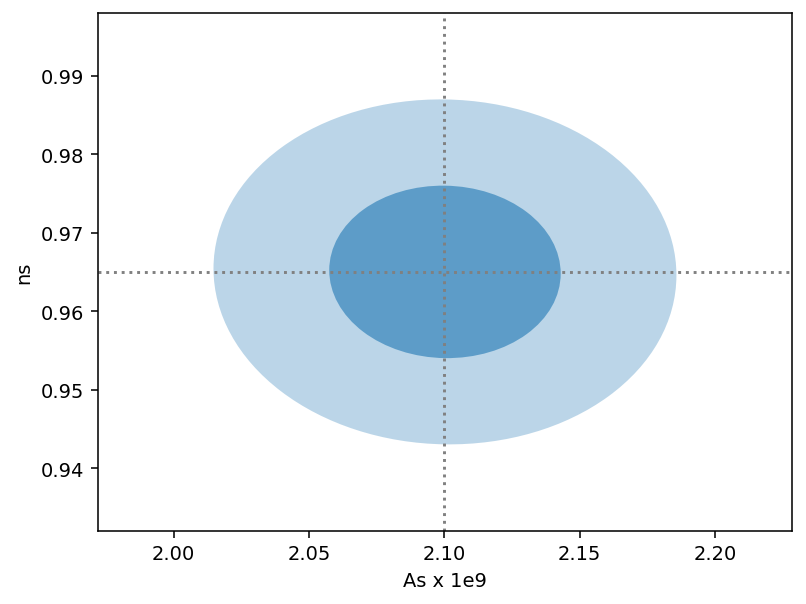

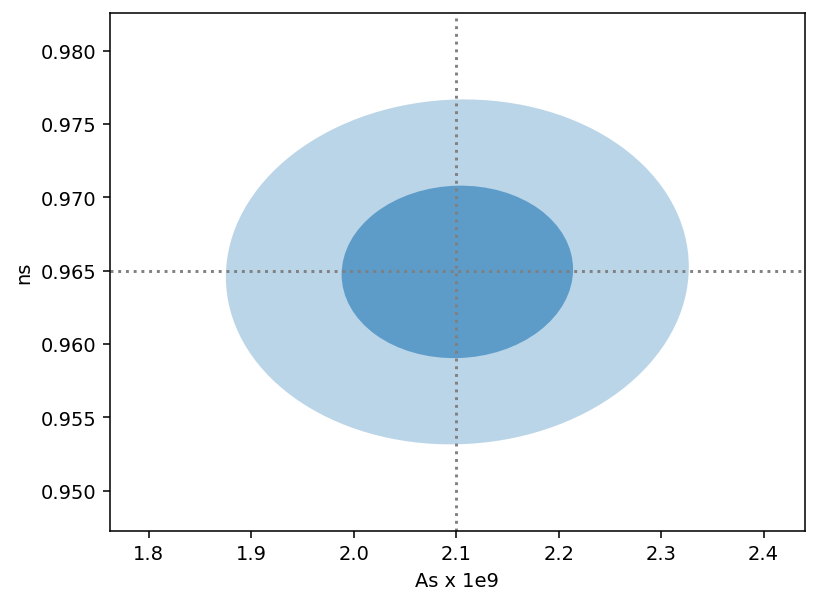

In [20]:
for label,run in runs.items():
    plt.figure()
    print('run',label)
    run['minimizer'].plot_ellipses('As','ns')
#     plt.savefig(label+'_As_ns.png')